## params

In [1]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa basemap CartoDB se contextily disponibile
}

In [2]:


# === AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]                   # polygon in WGS84 per query
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === EDIFICI (solo poligoni) ===
building_tags = {"building": True}

if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

# Filtro e proiezione
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)


# === Tag “verde” da OSM ===
# === TAG VERDI ESTESI (landuse, landcover, natural, leisure, ecc.) ===
tags = {
    # Aree ricreative e di svago
    "leisure": [
        "park", "garden", "recreation_ground", "nature_reserve",
        "golf_course", "dog_park", "playground", "pitch", "sports_centre",
        "stadium", "common"
    ],

    # Uso del suolo (agricolo, verde urbano, cimiteri, ecc.)
    "landuse": [
        "farmland", "farmyard", "meadow", "grass", "pasture",
        "orchard", "vineyard", "plant_nursery",
        "forest", "greenfield", "recreation_ground",
        "cemetery", "village_green", "allotments",
        "flowerbed", "greenhouse_horticulture",
        "reservoir", "basin", "salt_pond", "retail"
    ],

    # Elementi naturali (vegetazione, acque, terreni naturali)
    "natural": [
        "wood", "scrub", "grassland", "heath", "wetland",
        "tree", "tree_row", "shrub", "meadow", "field", "sand", "bare_rock"
    ],

    # Copertura del suolo (nuovo schema OSM)
    "landcover": [
        "grass", "trees", "bushes", "scrub", "farmland", "crop", "vineyard", "orchard"
    ],

    # Barriere e margini verdi (siepi, argini)
    "barrier": ["hedge"],

    # Manufatti con vegetazione (fioriere, argini, scarpate)
    "man_made": ["planter", "flowerbed", "embankment"],

    # Boundary: aree protette e riserve
    "boundary": ["protected_area"],

    # Superfici con verde o terriccio
    "surface": ["grass", "ground", "sand", "tartan", "dirt"],

    # Tag agricoli o generici (meno diffusi ma utili)
    "agriculture": True
}

# === Download geometrie OSM (compat v1/v2) ===
if hasattr(ox, "features_from_polygon"):          # OSMnx v2.x
    gdf = ox.features_from_polygon(aoi, tags=tags)
else:                                             # OSMnx v1.x
    gdf = ox.geometries_from_polygon(aoi, tags=tags)

# Tieni solo poligoni
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clip all'AOI
gdf = gpd.clip(gdf, aoi_gdf)

# Categoria (macro-chiave)
def classify_green_tripartite(row):
    """
    Classifica il verde OSM in tre categorie funzionali:
    - pubblico (parchi e aree ricreative)
    - produttivo (agricolo o a rendita)
    - altro (verde naturale o non classificato)
    """

    # --- VERDE PUBBLICO / RICREATIVO ---
    leisure_vals = [
        "park", "garden", "recreation_ground", "nature_reserve",
        "playground", "golf_course", "pitch", "sports_centre",
        "common", "village_green", "dog_park", "stadium"
    ]
    if str(row.get("leisure")) in leisure_vals:
        return "verde_pubblico"
    if str(row.get("landuse")) in ["recreation_ground", "cemetery"]:
        return "verde_pubblico"
    if str(row.get("man_made")) in ["planter", "flowerbed"]:
        return "verde_pubblico"

    # --- VERDE PRODUTTIVO / ECONOMICO ---
    landuse_agri = [
        "farmland", "farmyard", "meadow", "pasture",
        "orchard", "vineyard", "plant_nursery", "greenhouse_horticulture"
    ]
    if str(row.get("landuse")) in landuse_agri:
        return "verde_produttivo"
    if str(row.get("landcover")) in ["crop", "farmland", "orchard", "vineyard"]:
        return "verde_produttivo"
    if row.get("agriculture") is True:
        return "verde_produttivo"

    # --- ALTRO VERDE NON CLASSIFICATO ---
    # Include aree naturali, vegetazione spontanea, superfici verdi varie
    natural_vals = [
        "wood", "scrub", "grassland", "heath", "wetland",
        "tree", "tree_row", "meadow", "field", "sand", "bare_rock"
    ]
    if str(row.get("natural")) in natural_vals:
        return "verde_altro"
    if str(row.get("landcover")) in ["grass", "trees", "bushes", "shrub"]:
        return "verde_altro"
    if str(row.get("surface")) in ["grass", "ground", "tartan", "dirt"]:
        return "verde_altro"

    # Default
    return "verde_altro"


gdf["categoria_verde"] = gdf.apply(classify_green_tripartite, axis=1)

# === Plot (Web Mercator per basemap) ===
gdf3857 = gdf.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# --- ACQUE: poligoni e linee (OSM) ---
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

# Tieni solo poligoni/multipoligoni e clippa
water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

# Tieni solo LineString/MultiLineString e clippa
water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)
water_line3857 = water_line.to_crs(3857)

# --- FILTRO: tieni solo corsi d'acqua visibili (fiumi e canali, non sotterranei) ---
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
    water_line3857 = water_line_visible.to_crs(3857)
else:
    # fallback: se manca la colonna, lascio tutto
    water_line_visible = water_line


# Stili acqua
WATER_FILL = "#4aa3df"   # azzurro poligoni
WATER_EDGE = "#2c7fb8"   # bordo poligoni
WATER_LINE = "#2c7fb8"   # linee fiumi/rogge

# --- Opzioni layer leggeri ---
SHOW_ROADS = True
SHOW_LANDUSE_OUTLINES = True      # contorni sottili e tratteggiati
SHOW_LANDUSE_CENTROIDS = False    # alternative: puntini ai centroidi

# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

# --- LANDUSE: contorni/centroidi leggeri ---
landuse_gdf = gdf.loc[gdf["landuse"].notna()].copy()
landuse3857 = landuse_gdf.to_crs(3857)
landuse_centroids3857 = landuse3857.copy()
landuse_centroids3857["geometry"] = landuse_centroids3857.geometry.centroid


# === Palette e mapping categorie ===
palette = {
    "verde_pubblico": "#6ECF6A",     # verde brillante
    "verde_produttivo": "#A7D379",   # verde-giallognolo
    "verde_altro": "#9BC4A7"         # verde neutro/grigiastro
}

colors = gdf3857["categoria_verde"].map(palette)


# Usa direttamente la categoria funzionale tripartita
gdf3857_plot = gdf3857.copy()

# Mappa i colori coerenti
colors = gdf3857_plot["categoria_verde"].map(palette)





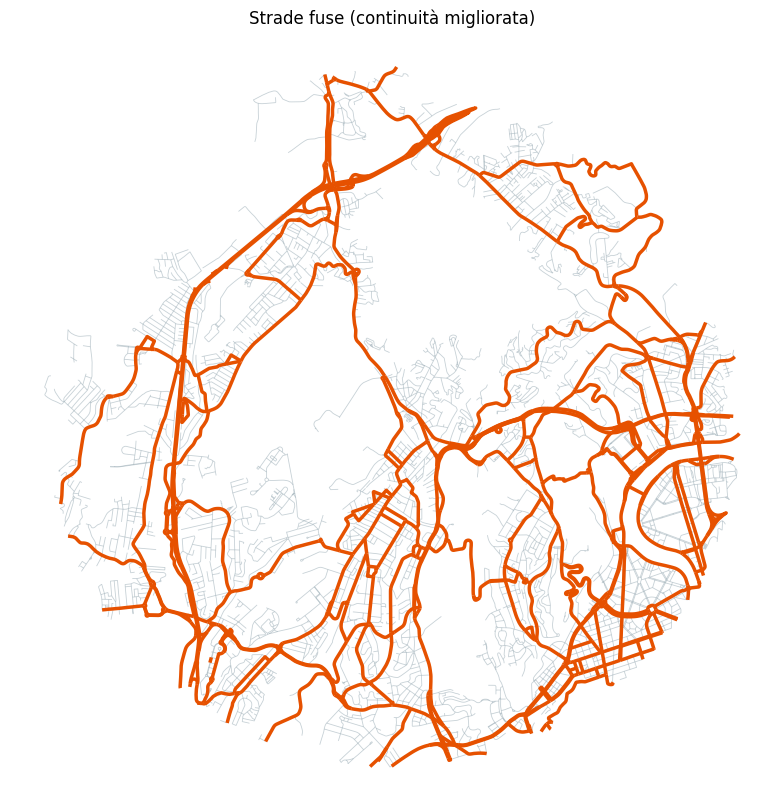

In [3]:
from shapely.ops import linemerge, unary_union

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

fig, ax = plt.subplots(figsize=(10, 10))
edges_minor_fused.plot(ax=ax, color="#90a4ae", linewidth=0.6, alpha=0.5)
edges_major_fused.plot(ax=ax, color="#e65100", linewidth=2.5)
plt.title("Strade fuse (continuità migliorata)")
plt.axis("off")
plt.show()



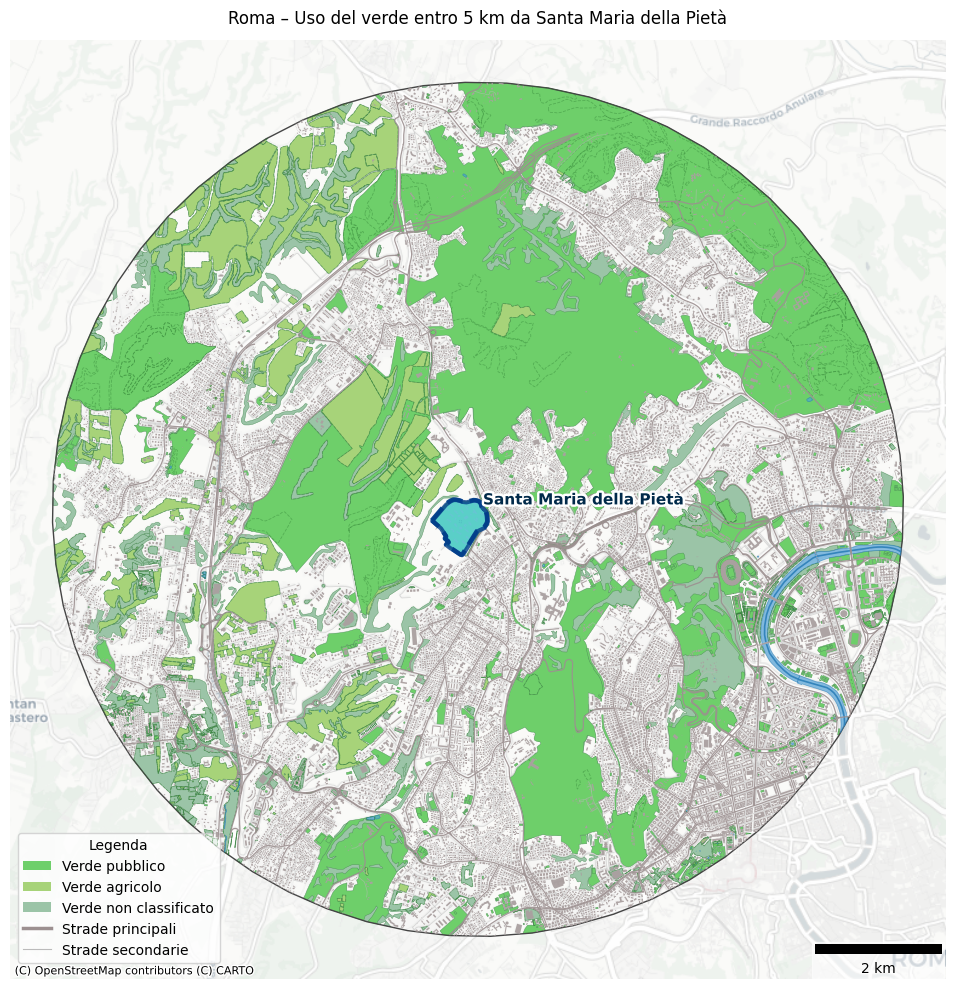

Creato file: mappa_verde_smdp.png


In [4]:
import pandas as pd
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10,10))

# --- AOI e verde ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0)
gdf3857_plot.plot(ax=ax, color=colors, edgecolor="#4F8F59", linewidth=0.3, alpha=1.0)


# --- Basemap (PRIMA di tutto, sotto a tutto) ---
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=gdf3857.crs,
            source=ctx.providers.CartoDB.Positron,
            zorder=-10
        )
    except Exception:
        pass

# --- ACQUE ---
if not water_poly3857.empty:
    water_poly3857.plot(
        ax=ax, facecolor=WATER_FILL, edgecolor=WATER_EDGE,
        linewidth=0.6, alpha=0.6, zorder=6
    )
if not water_line3857.empty:
    water_line3857.plot(
        ax=ax, color=WATER_LINE, linewidth=1.2, alpha=0.9, zorder=7
    )

# --- STRADE FUSE: principali e minori ---
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(
            ax=ax, linewidth=0.6, alpha=0.5,
            color=COLOR_MINOR, zorder=30
        )
    if not edges_major_fused.empty:
        edges_major_fused.plot(
            ax=ax, linewidth=0.9, alpha=0.9,
            color=COLOR_MAJOR, zorder=31
        )

# --- LANDUSE ---
if SHOW_LANDUSE_OUTLINES and not landuse3857.empty:
    landuse3857.boundary.plot(
        ax=ax, linewidth=0.6, linestyle="--", alpha=0.4, color="#2e7d32", zorder=8
    )
if SHOW_LANDUSE_CENTROIDS and not landuse_centroids3857.empty:
    ax.scatter(
        landuse_centroids3857.geometry.x, landuse_centroids3857.geometry.y,
        s=8, marker='o', color="#2e7d32", alpha=0.6, zorder=6
    )

# --- EDIFICI: disegnati sopra ---
if not buildings3857.empty:
    buildings3857.plot(
        ax=ax,
        color="#aaa0a0",  # o "#e6e6e6"
        edgecolor=None,
        linewidth=0.0,
        alpha=0.95,
        zorder=50
    )

# --- Legenda in italiano, spostata in alto ---
# --- Legenda in italiano, costruita dalle categorie presenti ---
etichetta_tripartite = {
    "verde_pubblico": "Verde pubblico",
    "verde_produttivo": "Verde agricolo",
    "verde_altro": "Verde non classificato"
}

handles = [
    Patch(facecolor=palette[k], edgecolor='none', label=etichetta_tripartite[k])
    for k in ["verde_pubblico", "verde_produttivo", "verde_altro"]
]
ax.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.001, 0.01), title="Tipologia di verde")


# Aggiungi la legenda delle strade solo se le strade sono state plottate
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    road_legend = [
        Line2D([0], [0], color=COLOR_MAJOR, lw=2.5, label="Strade principali"),
        Line2D([0], [0], color=COLOR_MINOR, lw=0.8, label="Strade secondarie")
    ]
    handles += road_legend

ax.legend(
    handles=handles,
    loc="lower left",
    bbox_to_anchor=(0.001, 0.01),
    title="Legenda"
)


# --- Titolo, scalebar ---
ax.set_axis_off()
ax.set_title("Roma – Uso del verde entro 5 km da Santa Maria della Pietà", pad=12)

import matplotlib_scalebar.scalebar as sb
scalebar = sb.ScaleBar(1, units="m", dimension="si-length", location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# --- Marker Santa Maria della Pietà (ULTIMO, sopra tutto) ---
# === Trova la geometria verde che contiene il punto ===
# punto: Santa Maria della Pietà
point_3857 = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326).to_crs(3857)
p = point_3857.geometry.iloc[0]

# (1) filtro "verdi"
gdf_verde = gdf3857[gdf3857["categoria_verde"].isin(
    ["verde_pubblico", "verde_produttivo", "verde_altro"]
)].copy()

# (2) trova geometrie che contengono/intersecano il punto
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()


# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.plot(
        ax=ax,
        color="#56CFE1",           # turchese brillante
        alpha=0.8,
        edgecolor="#023E8A",       # bordo blu profondo
        linewidth=3,
        zorder=150
    )
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#023E8A",
        linewidth=3.2,
        linestyle="--",
        alpha=0.95,
        zorder=151
    )

    # Etichetta con buona leggibilità
    for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
        ax.text(
            x + 80, y + 80, "Santa Maria della Pietà",
            fontsize=11, fontweight='bold',
            color="#012A4A",
            path_effects=[pe.withStroke(linewidth=3.5, foreground="white")],
            zorder=200
        )


# ax.scatter(
#     point_3857.geometry.x,
#     point_3857.geometry.y,
#     s=120, marker='*', color='#d62828', edgecolor='white', linewidth=1.5, zorder=100
# )
# for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
#     ax.text(
#         x + 50, y + 50, "Santa Maria della Pietà",
#         fontsize=10, fontweight='bold', color='#222222',
#         path_effects=[pe.withStroke(linewidth=3, foreground="white")],
#         zorder=101
#     )

plt.tight_layout()
# plt.savefig("mappa_verde_smdp.png", dpi=200, bbox_inches="tight")
plt.show()

print("Creato file: mappa_verde_smdp.png")


In [5]:
print(gdf3857["categoria_verde"].value_counts(dropna=False))


categoria_verde
verde_altro         1249
verde_pubblico       908
verde_produttivo     332
Name: count, dtype: int64


In [6]:
# Controlla quante geometrie non hanno categoria
mask_missing = gdf["categoria_verde"].isna()
n_missing = mask_missing.sum()
n_total = len(gdf)

print(f"Aree non classificate: {n_missing} su {n_total} ({100*n_missing/n_total:.2f}%)")

# Se ci sono aree non classificate, mostriamo alcune righe per capire perché
if n_missing > 0:
    display(gdf.loc[mask_missing, ["leisure", "landuse", "natural", "landcover", "man_made", "surface"]].head(20))


Aree non classificate: 0 su 2489 (0.00%)


In [7]:
# Quante geometrie totali (tutte OSM, non solo verdi)
print(f"Totale poligoni scaricati: {len(gdf)}")

# Stampa i campi chiave presenti
print(gdf.columns.tolist())

# Verifica la densità spaziale nella zona di interesse (dove vedi buchi)
from shapely.geometry import Point

point = Point(12.418912, 41.940583)  # Santa Maria della Pietà
radius_m = 1000

aoi_local = gpd.GeoDataFrame(geometry=[point.buffer(radius_m / 111_000)], crs=4326)  # 1 km in gradi

sub = gpd.clip(gdf, aoi_local)
print(f"Poligoni in un raggio di 1 km: {len(sub)}")


Totale poligoni scaricati: 2489
['geometry', 'natural', 'barrier', 'bicycle', 'foot', 'horse', 'motorcar', 'access', 'surface', 'leisure', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'contact:facebook', 'contact:phone', 'name', 'sport', 'taxon:family', 'denotation', 'leaf_cycle', 'leaf_type', 'taxon', 'taxon:it', 'motor_vehicle', 'opening_hours', 'species', 'genus', 'species:it', 'name:etymology:wikidata', 'species:en', 'source', 'height', 'man_made', 'material', 'wikidata', 'fence_type', 'wheelchair', 'description', 'highway', 'website', 'survey:date', 'diameter_crown', 'kerb', 'circumference', 'source:circumference', 'start_date', 'wikipedia', 'capacity', 'name:de', 'name:en', 'name:fr', 'name:it', 'wikimedia_commons', 'layer', 'mtb:scale', 'historic', 'created_by', 'lit', 'tracktype', 'landcover', 'landuse', 'name:es', 'name:ko', 'name:la', 'name:lt', 'width', 'bridge', 'alt_name', 'operator', 'phone', 'check_date', 'amenity', 'fee', 'park_ride', 'parking', 'old

## corine

In [8]:
import geopandas as gpd
import fiona

path_gdb = "/home/opc/CLC2018_IT.gdb/CLC2018_IT.gdb"

# Mostriamo i layer contenuti nel geodatabase
print("📚 Layer disponibili:")
layers = fiona.listlayers(path_gdb)
print(layers)


📚 Layer disponibili:
['CLC12_IT', 'CLC18_IT', 'CHA18_IT']


In [9]:
gdf = gpd.read_file("/home/opc/CLC2018_IT.gdb/CLC2018_IT.gdb", layer="CLC18_IT")
print(gdf.shape)
print(gdf.crs)
print(gdf.head())


(115782, 7)
EPSG:32632
   Shape_Length    Shape_Area    ID CODE_18     Area_Ha Remark  \
0   7714.624097  1.369207e+06  IT_1     111  136.920735   None   
1   3034.090575  3.566751e+05  IT_2     111   35.667510   None   
2   3038.123691  4.281445e+05  IT_3     111   42.814449   None   
3   4718.345385  5.815012e+05  IT_4     111   58.150121   None   
4   4389.084380  9.243629e+05  IT_5     111   92.436291   None   

                                            geometry  
0  MULTIPOLYGON (((827133.375 3935376.25, 827238....  
1  MULTIPOLYGON (((849078.188 3975021.25, 849189....  
2  MULTIPOLYGON (((1048555.786 4076865.387, 10485...  
3  MULTIPOLYGON (((762900.438 4080883.5, 763006.7...  
4  MULTIPOLYGON (((1022712.562 4081271.25, 102276...  


In [10]:
# === 2️⃣ Crea punto di riferimento (Santa Maria della Pietà) ===
center_latlon = PARAMS["center_latlon"]
point = gpd.GeoDataFrame(
    {"name": ["Santa Maria della Pietà"]},
    geometry=[Point(center_latlon[1], center_latlon[0])],
    crs="EPSG:4326"
)

# === 3️⃣ Proietta in CRS metrico (UTM 33N per Roma) ===
crs_metric = PARAMS["crs_metric"]
point_utm = point.to_crs(crs_metric)
gdf_utm = gdf.to_crs(crs_metric)

# === 4️⃣ Crea buffer di 5 km ===
buffer = point_utm.buffer(PARAMS["dist_m"])
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs=crs_metric)

# === 5️⃣ Ritaglia il Corine sul buffer ===
gdf_clip = gpd.overlay(gdf_utm, buffer_gdf, how="intersection")
print(f"✅ Poligoni ritagliati: {gdf_clip.shape[0]}")


✅ Poligoni ritagliati: 50


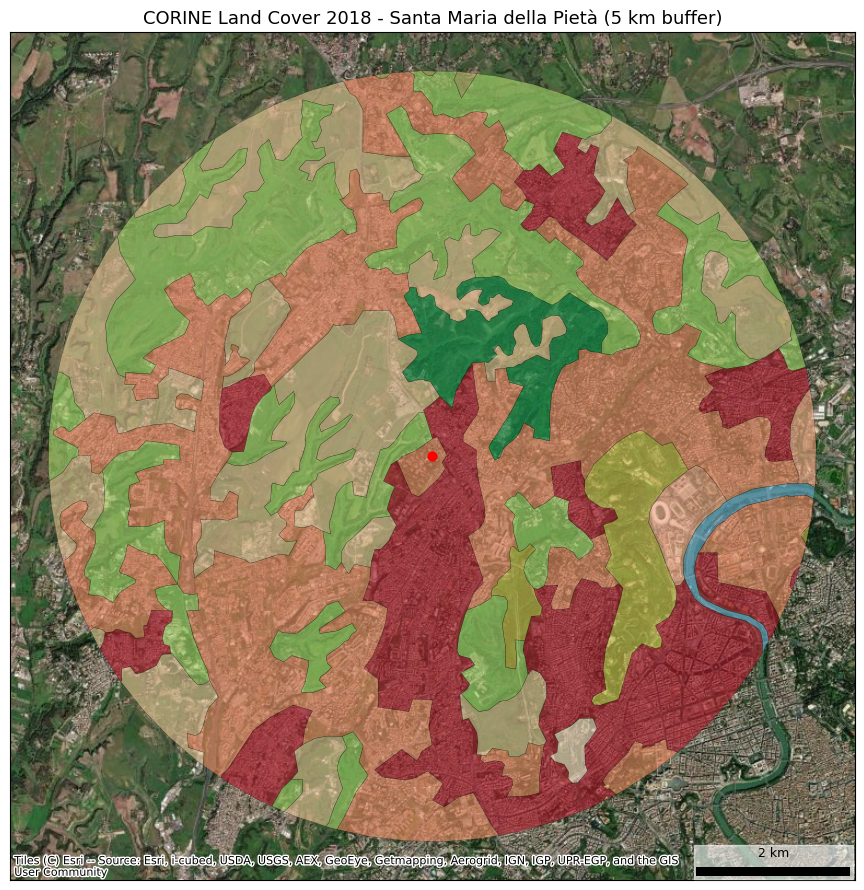

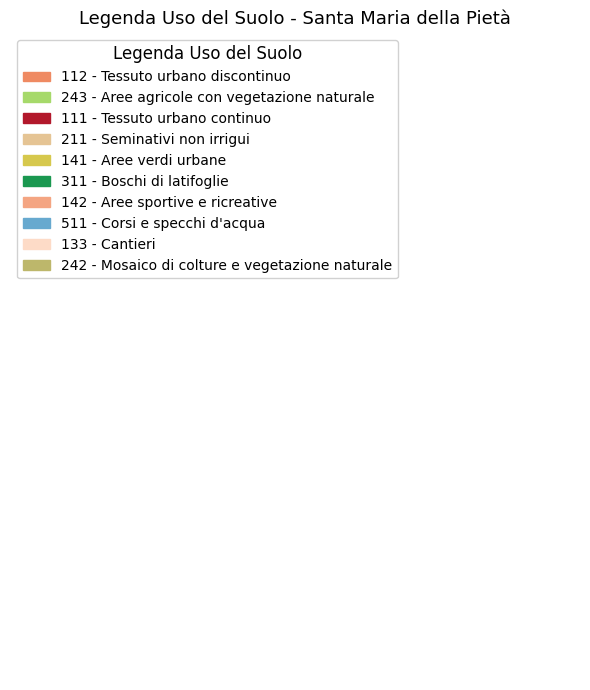

In [15]:
# ==============================================
# 1️⃣ Palette CORINE coerente
# ==============================================
import matplotlib.colors as mcolors

corine_palette = {
    '111': "#b2182b",  # urbano continuo
    '112': "#ef8a62",  # urbano discontinuo
    '133': "#fddbc7",  # cantieri
    '141': "#d6c84d",  # verde urbano
    '142': "#f4a582",  # aree sportive
    '211': "#e5c494",  # seminativi non irrigui
    '242': "#bdb76b",  # mosaico colture
    '243': "#a6d96a",  # agricole con vegetazione
    '311': "#1a9850",  # boschi di latifoglie
    '511': "#67a9cf",  # acqua
}

# ==============================================
# 2️⃣ Calcolo frequenze d’uso del suolo
# ==============================================
import pandas as pd

corine_labels_it = {
    '111': "Tessuto urbano continuo",
    '112': "Tessuto urbano discontinuo",
    '133': "Cantieri",
    '141': "Aree verdi urbane",
    '142': "Aree sportive e ricreative",
    '211': "Seminativi non irrigui",
    '242': "Mosaico di colture e vegetazione naturale",
    '243': "Aree agricole con vegetazione naturale",
    '311': "Boschi di latifoglie",
    '511': "Corsi e specchi d'acqua",
}

# Assicurati di lavorare in CRS metrico
gdf_clip = gdf_clip.to_crs(epsg=3857)
gdf_clip["area_m2"] = gdf_clip.geometry.area

# Frequenze e percentuali
df_freq = (
    gdf_clip.groupby("CODE_18")["area_m2"]
    .sum()
    .reset_index()
    .sort_values(by="area_m2", ascending=False)
)
df_freq["perc"] = 100 * df_freq["area_m2"] / df_freq["area_m2"].sum()
df_freq["descrizione"] = df_freq["CODE_18"].map(corine_labels_it)
df_freq["color"] = df_freq["CODE_18"].map(corine_palette)

# ==============================================
# 3️⃣ Mappa principale con colori CORINE coerenti
# ==============================================
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import math

# Conversione CRS
gdf_web = gdf_clip.to_crs(epsg=3857)
point_web = point_utm.to_crs(epsg=3857)

# Correzione per la scala metrica reale (latitudine di Roma)
lat0 = point_utm.to_crs(epsg=4326).geometry.y.iloc[0]
dx_correction = math.cos(math.radians(lat0))

fig, ax = plt.subplots(figsize=(9, 9))

# --- Plot CORINE con colori personalizzati ---
gdf_web["color"] = gdf_web["CODE_18"].map(corine_palette)
gdf_web.plot(ax=ax, color=gdf_web["color"], alpha=0.6, edgecolor="k", linewidth=0.2)

# --- Punto centrale ---
point_web.plot(ax=ax, color="red", markersize=40, zorder=3)

# --- Basemap ---
ctx.add_basemap(ax, crs=gdf_web.crs, source=ctx.providers.Esri.WorldImagery)

# --- Barra di scala bianca ---
scalebar = ScaleBar(
    dx=dx_correction,
    units="m",
    dimension="si-length",
    location="lower right",
    scale_loc="top",
    box_alpha=0.6,
    box_color=(1, 1, 1, 0.5),
    color="black",
    length_fraction=0.25,
    font_properties={'size': 9},
)
ax.add_artist(scalebar)

# --- Layout pulito ---
ax.set_title("CORINE Land Cover 2018 - Santa Maria della Pietà (5 km buffer)", fontsize=13)
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

# ==============================================
# 4️⃣ Legenda coerente e separata
# ==============================================
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 7))

# Categorie effettivamente presenti nel buffer
handles = [
    mpatches.Patch(color=row["color"], label=f"{row['CODE_18']} - {row['descrizione']}")
    for _, row in df_freq.iterrows()
]

ax.legend(
    handles=handles,
    title="Legenda Uso del Suolo",
    loc="upper left",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    framealpha=0.9
)
ax.set_title("Legenda Uso del Suolo - Santa Maria della Pietà", fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()


✅ Poligoni ritagliati: 50


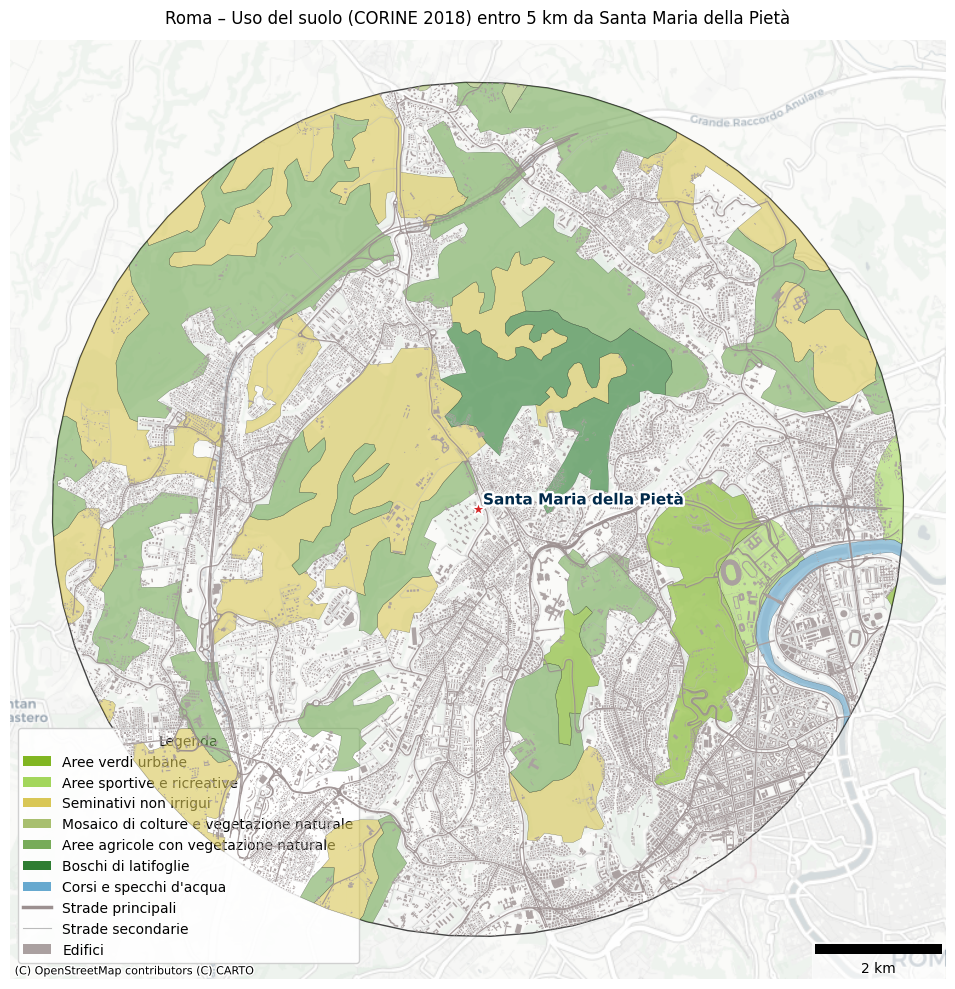

✅ Mappa finale: CORINE (verde + acqua) + OSM (strade, edifici)


In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib_scalebar.scalebar as sb
from shapely.geometry import Point

# =========================================================
# 1️⃣ Punto centrale e buffer (Santa Maria della Pietà)
# =========================================================
center_latlon = PARAMS["center_latlon"]     # (lat, lon)
crs_metric = PARAMS["crs_metric"]           # es. EPSG:32633
point = gpd.GeoDataFrame(
    {"name": ["Santa Maria della Pietà"]},
    geometry=[Point(center_latlon[1], center_latlon[0])],
    crs="EPSG:4326"
)
point_utm = point.to_crs(crs_metric)
gdf_utm = gdf.to_crs(crs_metric)

# Buffer 5 km
buffer = point_utm.buffer(PARAMS["dist_m"])
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs=crs_metric)

# Taglia CORINE sul buffer
gdf_clip = gpd.overlay(gdf_utm, buffer_gdf, how="intersection")
print(f"✅ Poligoni ritagliati: {gdf_clip.shape[0]}")

# =========================================================
# 2️⃣ Categorie CORINE (verde + acqua)
# =========================================================
corine_classi = {
    # verde vegetale
    '141': "Aree verdi urbane",
    '142': "Aree sportive e ricreative",
    '211': "Seminativi non irrigui",
    '242': "Mosaico di colture e vegetazione naturale",
    '243': "Aree agricole con vegetazione naturale",
    '311': "Boschi di latifoglie",
    # acqua
    '511': "Corsi e specchi d'acqua",
}

palette_corine = {
    '141': "#81B622",
    '142': "#A3D65C",
    '211': "#D9C756",
    '242': "#A8BF6F",
    '243': "#77AB59",
    '311': "#2E7D32",
    '511': "#67A9CF",  # acqua
}

# Filtra CORINE
gdf_corine = gdf_clip.to_crs(3857).query("CODE_18 in @corine_classi.keys()").copy()
gdf_corine["color"] = gdf_corine["CODE_18"].map(palette_corine)

# =========================================================
# 3️⃣ Setup figura principale
# =========================================================
fig, ax = plt.subplots(figsize=(10, 10))

# AOI da OSM (solo boundary)
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=1)

# =========================================================
# 4️⃣ Basemap
# =========================================================
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=aoi3857.crs,
            source=ctx.providers.CartoDB.Positron,
            zorder=-10
        )
    except Exception:
        pass

# =========================================================
# 5️⃣ Layer CORINE (verde + acqua)
# =========================================================
if not gdf_corine.empty:
    gdf_corine.plot(
        ax=ax,
        color=gdf_corine["color"],
        edgecolor="black",
        linewidth=0.2,
        alpha=0.6,
        zorder=20
    )

# =========================================================
# 6️⃣ Strade (da OSM)
# =========================================================
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(ax=ax, linewidth=0.6, alpha=0.5, color=COLOR_MINOR, zorder=30)
    if not edges_major_fused.empty:
        edges_major_fused.plot(ax=ax, linewidth=0.9, alpha=0.9, color=COLOR_MAJOR, zorder=31)

# =========================================================
# 7️⃣ Edifici (da OSM)
# =========================================================
if not buildings3857.empty:
    buildings3857.plot(ax=ax, color="#aaa0a0", edgecolor=None,
                       linewidth=0.0, alpha=0.95, zorder=50)

# =========================================================
# 8️⃣ Legenda CORINE + OSM
# =========================================================
handles = [
    Patch(facecolor=palette_corine[k], edgecolor='none', label=f"{corine_classi[k]}")
    for k in corine_classi.keys()
]

if SHOW_ROADS:
    road_legend = [
        Line2D([0], [0], color=COLOR_MAJOR, lw=2.5, label="Strade principali"),
        Line2D([0], [0], color=COLOR_MINOR, lw=0.8, label="Strade secondarie")
    ]
    handles += road_legend

handles.append(Patch(facecolor="#aaa0a0", edgecolor='none', label="Edifici"))

ax.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.001, 0.01),
          title="Legenda", frameon=True, framealpha=0.9)

# =========================================================
# 9️⃣ Titolo, scalebar, evidenzia punto
# =========================================================
ax.set_axis_off()
ax.set_title("Roma – Uso del suolo (CORINE 2018) entro 5 km da Santa Maria della Pietà", pad=12)

scalebar = sb.ScaleBar(1, units="m", dimension="si-length",
                       location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# Punto centrale evidenziato
point_3857 = point.to_crs(3857)
for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(x + 80, y + 80, "Santa Maria della Pietà",
            fontsize=11, fontweight='bold', color="#012A4A",
            path_effects=[pe.withStroke(linewidth=3.5, foreground="white")],
            zorder=200)
    ax.scatter(x, y, s=120, marker='*', color='#d62828',
               edgecolor='white', linewidth=1.2, zorder=199)

plt.tight_layout()
plt.show()
print("✅ Mappa finale: CORINE (verde + acqua) + OSM (strade, edifici)")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib_scalebar.scalebar as sb
from shapely.geometry import Point

# =========================================================
# 1️⃣ Punto centrale e buffer (Santa Maria della Pietà)
# =========================================================
center_latlon = PARAMS["center_latlon"]     # (lat, lon)
crs_metric = PARAMS["crs_metric"]           # es. EPSG:32633
point = gpd.GeoDataFrame(
    {"name": ["Santa Maria della Pietà"]},
    geometry=[Point(center_latlon[1], center_latlon[0])],
    crs="EPSG:4326"
)
point_utm = point.to_crs(crs_metric)
gdf_utm = gdf.to_crs(crs_metric)

# Buffer 5 km
buffer = point_utm.buffer(PARAMS["dist_m"])
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs=crs_metric)

# Taglia CORINE sul buffer
gdf_clip = gpd.overlay(gdf_utm, buffer_gdf, how="intersection")
print(f"✅ Poligoni ritagliati: {gdf_clip.shape[0]}")

# =========================================================
# 2️⃣ Categorie CORINE (verde + acqua)
# =========================================================
corine_classi = {
    # verde vegetale
    '141': "Aree verdi urbane",
    '142': "Aree sportive e ricreative",
    '211': "Seminativi non irrigui",
    '242': "Mosaico di colture e vegetazione naturale",
    '243': "Aree agricole con vegetazione naturale",
    '311': "Boschi di latifoglie",
    # acqua
    '511': "Corsi e specchi d'acqua",
}

palette_corine = {
    '141': "#81B622",
    '142': "#A3D65C",
    '211': "#D9C756",
    '242': "#A8BF6F",
    '243': "#77AB59",
    '311': "#2E7D32",
    '511': "#67A9CF",  # acqua
}

# Filtra CORINE
gdf_corine = gdf_clip.to_crs(3857).query("CODE_18 in @corine_classi.keys()").copy()
gdf_corine["color"] = gdf_corine["CODE_18"].map(palette_corine)

# =========================================================
# 3️⃣ Setup figura principale
# =========================================================
fig, ax = plt.subplots(figsize=(10, 10))

# AOI da OSM (solo boundary)
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=1)

# =========================================================
# 4️⃣ Basemap
# =========================================================
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=aoi3857.crs,
            source=ctx.providers.CartoDB.Positron,
            zorder=-10
        )
    except Exception:
        pass

# =========================================================
# 5️⃣ Layer CORINE (verde + acqua)
# =========================================================
if not gdf_corine.empty:
    gdf_corine.plot(
        ax=ax,
        color=gdf_corine["color"],
        edgecolor="black",
        linewidth=0.2,
        alpha=0.6,
        zorder=20
    )

# =========================================================
# 6️⃣ Strade (da OSM)
# =========================================================
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(ax=ax, linewidth=0.6, alpha=0.5, color=COLOR_MINOR, zorder=30)
    if not edges_major_fused.empty:
        edges_major_fused.plot(ax=ax, linewidth=0.9, alpha=0.9, color=COLOR_MAJOR, zorder=31)

# =========================================================
# 7️⃣ Edifici (da OSM)
# =========================================================
if not buildings3857.empty:
    buildings3857.plot(ax=ax, color="#aaa0a0", edgecolor=None,
                       linewidth=0.0, alpha=0.95, zorder=50)

# =========================================================
# 8️⃣ Legenda CORINE + OSM
# =========================================================
handles = [
    Patch(facecolor=palette_corine[k], edgecolor='none', label=f"{corine_classi[k]}")
    for k in corine_classi.keys()
]

if SHOW_ROADS:
    road_legend = [
        Line2D([0], [0], color=COLOR_MAJOR, lw=2.5, label="Strade principali"),
        Line2D([0], [0], color=COLOR_MINOR, lw=0.8, label="Strade secondarie")
    ]
    handles += road_legend

handles.append(Patch(facecolor="#aaa0a0", edgecolor='none', label="Edifici"))

ax.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.001, 0.01),
          title="Legenda", frameon=True, framealpha=0.9)

# =========================================================
# 9️⃣ Titolo, scalebar, evidenzia punto
# =========================================================
ax.set_axis_off()
ax.set_title("Roma – Uso del suolo (CORINE 2018) entro 5 km da Santa Maria della Pietà", pad=12)

scalebar = sb.ScaleBar(1, units="m", dimension="si-length",
                       location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# Punto centrale evidenziato
point_3857 = point.to_crs(3857)
for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(x + 80, y + 80, "Santa Maria della Pietà",
            fontsize=11, fontweight='bold', color="#012A4A",
            path_effects=[pe.withStroke(linewidth=3.5, foreground="white")],
            zorder=200)
    ax.scatter(x, y, s=120, marker='*', color='#d62828',
               edgecolor='white', linewidth=1.2, zorder=199)

plt.tight_layout()
plt.show()
print("✅ Mappa finale: CORINE (verde + acqua) + OSM (strade, edifici)")
